# An introduction to Power Calculations for GWAS Traits

### What is Statistical Power?

When we are doing genetic studies we're often asking the question: "Does carrying this genetic variant impact your level of trait X". This means that for each variant, we have to conduct a statistical test, where there are four different potential outcomes (assuming we actually know the truth - which in the real world we do not!): 


  Test/Truth   | True  | False |
------| ------------- | ------------- |
True  | Correct Rejection  | False-Positive  |
False | False-Negative  | Correct Anti-Rejection  |


What we typically want to do is make sure that we are maximizing the ratio of `Correct Rejection / (Correct-Rejection + False-Negatives)`, otherwise known as "statistical power". Thought another way, if we have 90% power for detecting an effect that we know comes from a non-zero effect then we can feel quite confident about those that are rejected!

For a broader summary of statistical power in the GWAS context, please see this tutorial: https://www.mv.helsinki.fi/home/mjxpirin/GWAS_course/material/GWAS3.html


### Key parameters of interest

* **"Sample-Size" ($N$)**: How many individuals we have sampled and have phenotypic measurements for.
* "Effect-Size" ($\beta$): How large the underlying causal effect is, in units of standard deviations typically
* "Minor Allele Frequency" (MAF): How rare is the allele that is causing the intended effect? (e.g. a MAF of 1% means 1/50 people will carry the allele)
* "Imputation $R^2$" or "Tagging $R^2$ " (r2): This is a statement of how correlated the underlying variant is to the actual *true* variant. In most cases this will be quite high (r2 > 0.9), but for rare variants this can be quite low.
* "Proportion of Cases": The proportion of cases in a dataset for a binary trait (e.g. 10% of the individuals in the dataset have diabetes, so they are cases).


### Key Questions you will be able to address in this notebook

* Estimate the sample-size required to detect an allele at a specific frequency and effect-size threshold with a specific amount of power.
* Estimate the $\beta$ - MAF relationship for a specific sample-size and power-threshold.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import sys
sys.path.append('../qtl_power/')
from gwas import GwasQuant, GwasBinary

%matplotlib inline

## Evaluating Power for Quantitative Traits under Simple Linear Regression

### Effect-Size vs Power as a function of Sample-Size

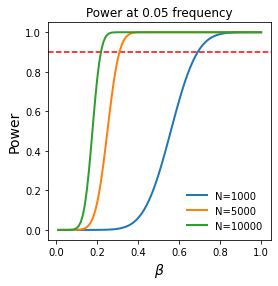

In [2]:
# NOTE: this is for an example like LDL-cholesterol levels 
ns = [1000, 5000, 10000] # Sample-Sizes to evaluate
min_beta = 0.01 # Minimum Effect-Size
max_beta = 1.0 # Maximum Effect-Size
maf = 0.05 # Target Minor-Allele Frequency
r2 = 1 # Minimum r2 from imputation
target_power = 0.90 # Target Power
alpha = 5e-8 #The p-value threshold for a GWAS (typically)

# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 
# Setting up the figure 
betas = np.linspace(min_beta, max_beta, 100)
gwas_power = GwasQuant()
fig, ax = plt.subplots(1,1,figsize=(4,4))

# Draw the line for the target amount of power
# NOTE: the point at which they intersect the line is the effect-size that is detectable (it should shift leftward as N increases!)
ax.axhline(y=target_power, linestyle='--', color='red')

# For each sample-size, draw the curve for power to detect as a function of effect-size.
for n in ns:
    powers = [gwas_power.quant_trait_power(n=n, beta=b, r2=r2, p=maf, alpha=alpha) for b in betas]
    ax.plot(betas, powers, lw=2, label=f'N={n}')

# Setup the axis labels ... 
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel('Power', fontsize=14)
ax.set_title(f'Power at {maf} frequency')
ax.legend(frameon=False)

### MAF vs. Effect-Size as a function of Sample-Size 

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Text(0.5, 0, 'MAF')

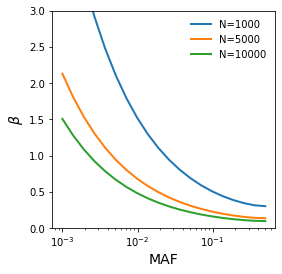

In [3]:
ns = [1000, 5000, 10000] # Sample-Sizes
min_maf = 0.001
max_maf = 0.5
r2=1.0
target_power = 0.9
alpha = 5e-8

# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 
fig, ax = plt.subplots(1,1,figsize=(4,4))
gwas_power = GwasQuant()
# Setup the grid of minor-allele frequencies
ps = np.logspace(np.log10(min_maf), np.log10(max_maf), 20) # 20 points offers decent speed ...

# For each sample-size, find the MAF-beta curve that meets this power demand
# NOTE: lower is always better in this case!
for n in tqdm(ns):
    opt_betas = [gwas_power.quant_trait_beta_power(n=n, p=p, power=target_power, r2=r2, alpha=alpha) for p in ps]
    ax.plot(ps, opt_betas, lw=2, label=f'N={n}')

ax.set_xscale('log') # scaling the x-axis by the log of the frequency 
ax.set_ylim(0, 3) # limiting the y-axis
ax.legend(frameon=False)
ax.set_ylabel(r'$\beta$', fontsize=14)
ax.set_xlabel(r'MAF', fontsize=14)

## Evaluating Power for Case/Control Traits 

### Effect-Size vs. Power as a function of Sample-Size

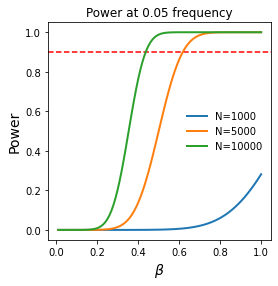

In [4]:
# NOTE: this is for an example like cases of sickle-cell anemia for example ... 
ns = [1000, 5000, 10000] # Sample-Sizes to evaluate
min_beta = 0.01 # Minimum Effect-Size
max_beta = 1.0 # Maximum Effect-Size
maf = 0.05 # Target Minor-Allele Frequency
r2 = 1 # Minimum r2 from imputation
target_power = 0.90 # Target Power
alpha = 5e-8 #The p-value threshold for a GWAS (typically)
prop_cases = 0.5 # the proportion of cases in the dataset (0.5 is the best!)


# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 
# Setting up the figure 
betas = np.linspace(min_beta, max_beta, 100)
gwas_power = GwasBinary()
fig, ax = plt.subplots(1,1,figsize=(4,4))

# Draw the line for the target amount of power
# NOTE: the point at which they intersect the line is the effect-size that is detectable (it should shift leftward as N increases!)
ax.axhline(y=target_power, linestyle='--', color='red')

# For each sample-size, draw the curve for power to detect as a function of effect-size.
for n in ns:
    powers = [gwas_power.binary_trait_power(n=n, beta=b, r2=r2, p=maf, alpha=alpha, prop_cases=prop_cases) for b in betas]
    ax.plot(betas, powers, lw=2, label=f'N={n}')

# Setup the axis labels ... 
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel('Power', fontsize=14)
ax.set_title(f'Power at {maf} frequency')
ax.legend(frameon=False)

### MAF vs. Effect-Size as a function of Sample-Size (for a specified Power)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Text(0.5, 0, 'MAF')

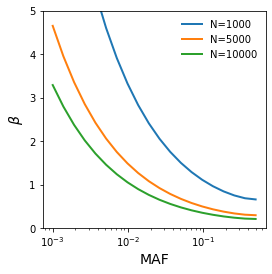

In [5]:
ns = [1000, 5000, 10000] # Sample-Sizes
min_maf = 0.001
max_maf = 0.5
r2=1.0
target_power = 0.9
alpha = 5e-8
prop_cases = 0.3 # Proportion of cases: the closer to 0.5 that this gets, the better ... 


fig, ax = plt.subplots(1, 1, figsize=(4,4))
ps = np.logspace(np.log10(min_maf), np.log10(max_maf), 20)
gwas_power = GwasBinary()
for n in tqdm(ns):
    opt_betas = [gwas_power.binary_trait_beta_power(n=n, p=p, power=target_power, prop_cases=prop_cases) for p in ps]
    ax.plot(ps, opt_betas, lw=2, label=f'N={n}')

ax.set_xscale('log')
ax.set_ylim(0, 5)
ax.legend(frameon=False)
ax.set_ylabel(r'$\beta$', fontsize=14)
ax.set_xlabel(r'MAF', fontsize=14)